Cell 1: Installation and Imports

In [6]:
# Install necessary libraries
!pip install tensorflow
!pip install --upgrade pip
!pip install xgboost
!pip install fastf1
!pip install seaborn

# Importing necessary libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import fastf1 #For real-time F1 telemetry data

Cell 2: Loading the Datasets

In [9]:
# Loading the datasets
race_results = pd.read_csv("/content/cleaned_results.csv")
lap_times = pd.read_csv("/content/cleaned_lap_times.csv")
pit_stops = pd.read_csv("/content/cleaned_pit_stops.csv")
weather_data = pd.read_csv("/content/Cleaned_F1_Weather.csv")


Cell 3: Exploring the Data

In [10]:
# Exploring the Data
print("race_results columns:", race_results.columns)
print("lap_times columns:", lap_times.columns)
print("pit_stops columns:", pit_stops.columns)
print("weather_data columns:", weather_data.columns)

race_results columns: Index(['resultId', 'raceId', 'driverId', 'constructorId', 'grid_position',
       'position', 'points', 'laps', 'fastestLap', 'fastestLapRank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId'],
      dtype='object')
lap_times columns: Index(['raceId', 'driverId', 'lap', 'position', 'lap_time'], dtype='object')
pit_stops columns: Index(['raceId', 'driverId', 'stop', 'lap', 'milliseconds'], dtype='object')
weather_data columns: Index(['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'Round Number', 'Year'],
      dtype='object')


Cell 4 Loading Race Information

In [11]:
# Loading Race Information
races = pd.read_csv("/content/cleaned_races.csv")
print(races.columns)

Index(['raceId', 'year', 'round', 'circuitId'], dtype='object')


Cell 5: Merging Weather Data with Race Information

In [12]:
# Merging Weather Data with Race Information
#Rename columns for consistency
weather_data.rename(columns={"Year": "year", "Round Number": "round"}, inplace=True)

#Merge races with weather_data using "year" and "round"
weather_merged = races.merge(weather_data, on=["year", "round"], how="left")

Cell 6: Merging Race Results with Weather Data 

In [13]:
# Merging Race Results with Weather Data
df = race_results.merge(weather_merged, on="raceId", how="left")

Cell 7: Initial Data Inspection

In [14]:
# Initial Data Inspection
print(df.head())  # Show first few rows
print(df.columns)  # Check available columns

   resultId  raceId  driverId  constructorId  grid_position  position  points  \
0         1      18         1              1              1         1    10.0   
1         2      18         2              2              5         2     8.0   
2         3      18         3              3              7         3     6.0   
3         4      18         4              4             11         4     5.0   
4         5      18         5              1              3         5     4.0   

   laps  fastestLap  fastestLapRank  ... round  circuitId  Time  AirTemp  \
0    58          39               2  ...     1          1   NaN      NaN   
1    58          41               3  ...     1          1   NaN      NaN   
2    58          41               5  ...     1          1   NaN      NaN   
3    58          58               7  ...     1          1   NaN      NaN   
4    58          43               1  ...     1          1   NaN      NaN   

   Humidity  Pressure Rainfall  TrackTemp  WindDirection

Cell 8: Merging All Datasets 

In [ ]:
# Merge datasets on race_id and driver_id
df = race_results.merge(lap_times, on=["raceId", "driverId"], how="left")
df = df.merge(pit_stops, on=["raceId", "driverId"], how="left")
df = df.merge(weather_merged, on=["raceId"], how="left")






Cell 9: Displaying All Columns

In [19]:
# Displaying All Columns
print(df.columns)  # Display all column names

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'grid_position',
       'position_x', 'points', 'laps', 'fastestLap', 'fastestLapRank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'lap_x', 'position_y',
       'lap_time', 'stop', 'lap_y', 'milliseconds', 'year', 'round',
       'circuitId', 'Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall',
       'TrackTemp', 'WindDirection', 'WindSpeed'],
      dtype='object')


Cell 10: Inspecting Position Columns

In [20]:
# Inspecting Position Columns
print(df[["position_x", "position_y"]].head())

   position_x  position_y
0           1         NaN
1           2         NaN
2           3         NaN
3           4         NaN
4           5         NaN


Cell 11: Handling Position Columns

In [21]:
# Handling Position Columns
df = df.drop(columns=["position_y"])  # Keep only "position_x"
df.rename(columns={"position_x": "position"}, inplace=True)  # Rename for clarity

print(df.columns)  # Verify changes


Index(['resultId', 'raceId', 'driverId', 'constructorId', 'grid_position',
       'position', 'points', 'laps', 'fastestLap', 'fastestLapRank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'lap_x', 'lap_time',
       'stop', 'lap_y', 'milliseconds', 'year', 'round', 'circuitId', 'Time',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed'],
      dtype='object')


Cell 12: Dropping Unnecessary Columns

In [22]:
# Dropping Unnecessary Columns
columns_to_drop = ["statusId"]  # Remove "positionOrder" since it's not in the DataFrame

# Drop only existing columns
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

print("Updated DataFrame columns:", df.columns)


Updated DataFrame columns: Index(['resultId', 'raceId', 'driverId', 'constructorId', 'grid_position',
       'position', 'points', 'laps', 'fastestLap', 'fastestLapRank',
       'fastestLapTime', 'fastestLapSpeed', 'lap_x', 'lap_time', 'stop',
       'lap_y', 'milliseconds', 'year', 'round', 'circuitId', 'Time',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed'],
      dtype='object')


Cell 13: Handling Missing Values

In [23]:
# Handling Missing Values
df.fillna(method="ffill", inplace=True)

<ipython-input-23-f1ce73c3d712>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


Cell 14: Displaying Available Columns 

In [24]:
# Displaying Available Columns 
print("Available columns:", df.columns)

Available columns: Index(['resultId', 'raceId', 'driverId', 'constructorId', 'grid_position',
       'position', 'points', 'laps', 'fastestLap', 'fastestLapRank',
       'fastestLapTime', 'fastestLapSpeed', 'lap_x', 'lap_time', 'stop',
       'lap_y', 'milliseconds', 'year', 'round', 'circuitId', 'Time',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed'],
      dtype='object')


Cell 15: Verifying Columns 

In [25]:
# Verifying Columns 
print(df.columns)

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'grid_position',
       'position', 'points', 'laps', 'fastestLap', 'fastestLapRank',
       'fastestLapTime', 'fastestLapSpeed', 'lap_x', 'lap_time', 'stop',
       'lap_y', 'milliseconds', 'year', 'round', 'circuitId', 'Time',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed'],
      dtype='object')


Cell 16: Renaming Grid Columns 

In [26]:
# Renaming Grid Column
# Rename 'grid_position' to 'grid' if needed
df.rename(columns={"grid_position": "grid"}, inplace=True)

Cell 17: Identifying Categorical Columns 

In [27]:
# Identifying Categorical Columns 
# Check available categorical columns
categorical_columns = ["constructorId", "grid"]  # 'weather' is missing from the dataset

Creates a new list called `existing_columns` that only contains the columns from `categorical_columns` that actually exist in the DataFrame `df`.
This prevents errors if a column specified in `categorical_columns` is not present in the DataFrame.


Cell 18: Filtering Existing Categorical Columns 

In [28]:
# Filtering Existing Categorical Columns 
# Ensure only existing columns are processed
existing_columns = [col for col in categorical_columns if col in df.columns]

Cell 19: One-Hot Encoding Categorical Features

In [29]:
# One-Hot Encoding Categorical Features
if existing_columns:
    df = pd.get_dummies(df, columns=existing_columns, drop_first=True)
    print("One-hot encoding applied to:", existing_columns)
else:
    print("No categorical columns found for encoding.")

One-hot encoding applied to: ['constructorId', 'grid']


Cell 20: Feature Scaling and Target Variable Selection

In [31]:
# Feature Scaling and Target Variable Selection
scaler = StandardScaler()
X = df.drop ("position", axis = 1) #Predicting final race position
y = df["position"]

Cell 21: Data Type Conversion

In [38]:
# Data Type Conversion
X = X.astype({col: "float32" for col in X.select_dtypes(include="float64").columns})
X = X.astype({col: "int32" for col in X.select_dtypes(include="int64").columns})

Cell 22: Importing Train-Test Split Function

In [33]:
# Importing Train-Test Split Function
from sklearn.model_selection import train_test_split

Cell 23: Data Sampling (Optional)

In [34]:
# Data Sampling (Optional)
# Reduce dataset to 50% size
X_sampled, y_sampled = X.sample(frac=0.5, random_state=42), y.sample(frac=0.5, random_state=42)

Cell 24: Splitting Data into Training and Testing Sets

In [35]:
# Splitting Data into Training and Testing Sets
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Cell 25: Handling Time and Duration Columns and Applying Feature Scaling

In [46]:
# Handling Time and Duration Columns and Applying Feature Scaling 
# Convert 'Time' column to total seconds if it exists, applying to both train and test sets

if "Time" in X_train.columns:
    X_train["Time"] = pd.to_timedelta(X_train["Time"])  # Convert to timedelta format
    X_train["Time"] = X_train["Time"].dt.total_seconds()  # Convert to total seconds

if "Time" in X_test.columns:
    X_test["Time"] = pd.to_timedelta(X_test["Time"])  # Convert to timedelta format
    X_test["Time"] = X_test["Time"].dt.total_seconds()  # Convert to total seconds

# Identify other potential time/duration columns
# Instead of using str.contains, check for object dtype and attempt conversion
time_duration_cols = X_train.select_dtypes(include=['object']).columns
# Convert potential time/duration columns in both train and test sets
for col in time_duration_cols:
    try:  # Attempt conversion, handle errors gracefully
        if col in X_train.columns:
            X_train[col] = pd.to_timedelta(X_train[col]).dt.total_seconds()
        if col in X_test.columns:
            X_test[col] = pd.to_timedelta(X_test[col]).dt.total_seconds()
    except (ValueError, TypeError):
        print(f"Column '{col}' could not be converted to timedelta, skipping.")

# Apply StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Column 'Rainfall' could not be converted to timedelta, skipping.


Cell 26: Model Training XGBoost Regressor

In [47]:
# Model Training: XGBoost Regressor
# Train XGBoost Model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)


# Model Prediction
# Predict
y_pred = model_xgb.predict(X_test)

# Model Evaluation
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost MSE: {mse}, R2 Score: {r2}")




XGBoost MSE: 1.014795184135437, R2 Score: 0.9698625802993774


Cell 28: Installing FastAPI

In [60]:
# Installing FastAPI
!pip install fastapi


Cell 29: Installing uvicorn

In [61]:
# Installing uvicorn
pip install uvicorn

Cell 30: Setting up FastAPI Application

In [63]:
# Setting Up FastAPI Application
import uvicorn
import nest_asyncio
from fastapi import FastAPI

# Allow running FastAPI inside Jupyter Notebook
nest_asyncio.apply()

# Create a FastAPI instance
app = FastAPI()

@app.get("/")
def read_root():
    return {"message": "Hello, FastAPI from Colab!"}

# Run Uvicorn server
uvicorn.run(app, host="0.0.0.0", port=8000)
#uvicorn.run(app, host="0.0.0.0", port=8000) #Commented out to avoid conflict during exploration


INFO:     Started server process [525]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [525]


Cell 30: Creating Prediciton Endpoint with FastAPI

In [78]:
# Creating Prediction Endpoint with FastAPI
import numpy as np

app = FastAPI()

@app.post("/predict")
def predict_strategy(data: dict):
    features = np.array(data["features"]).reshape(1, -1)
    prediction = model_xgb.predict(features)
    return {"predicted_position": prediction.tolist()}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [525]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [525]


Cell 31: Exploratory Data Analysis: Lap Time Distribution: Visualization

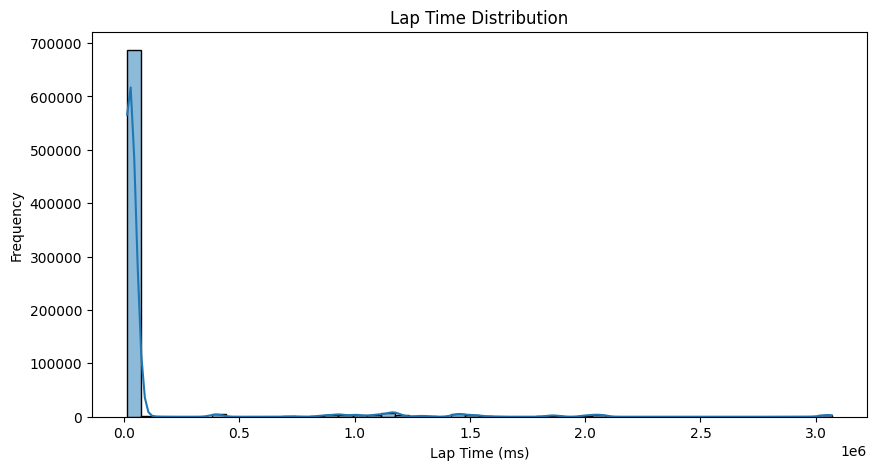

<ipython-input-104-8cd4d4eb10b6>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, palette="viridis")


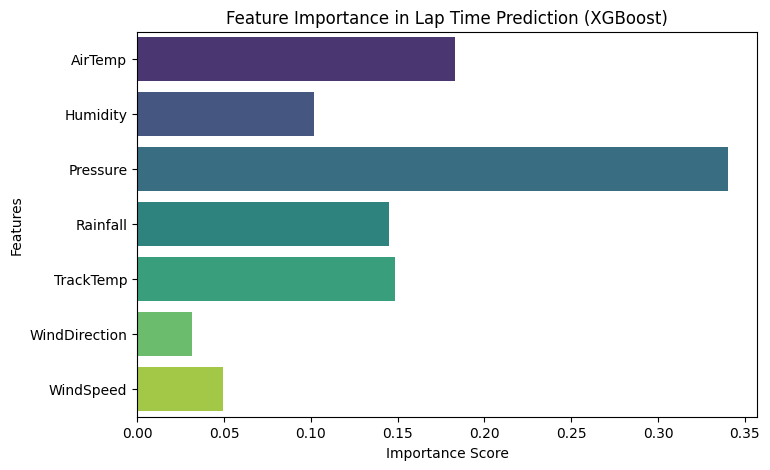

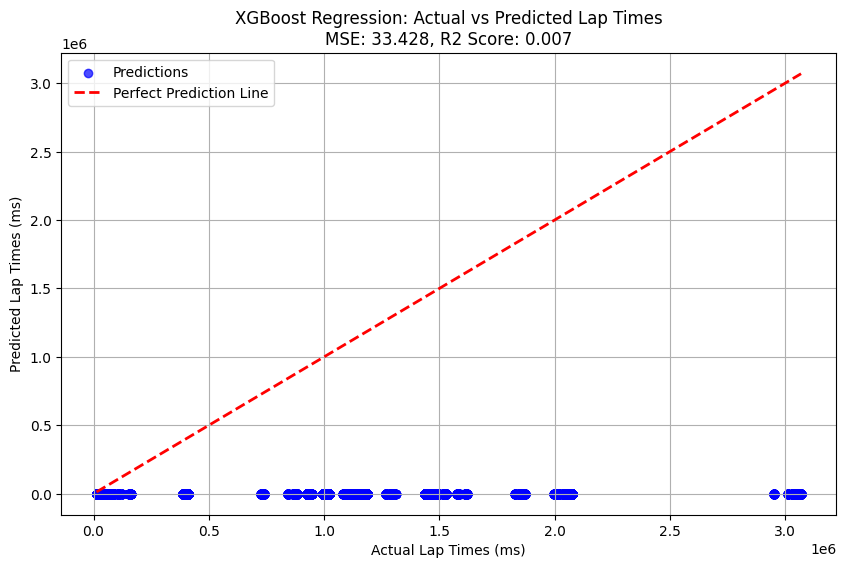

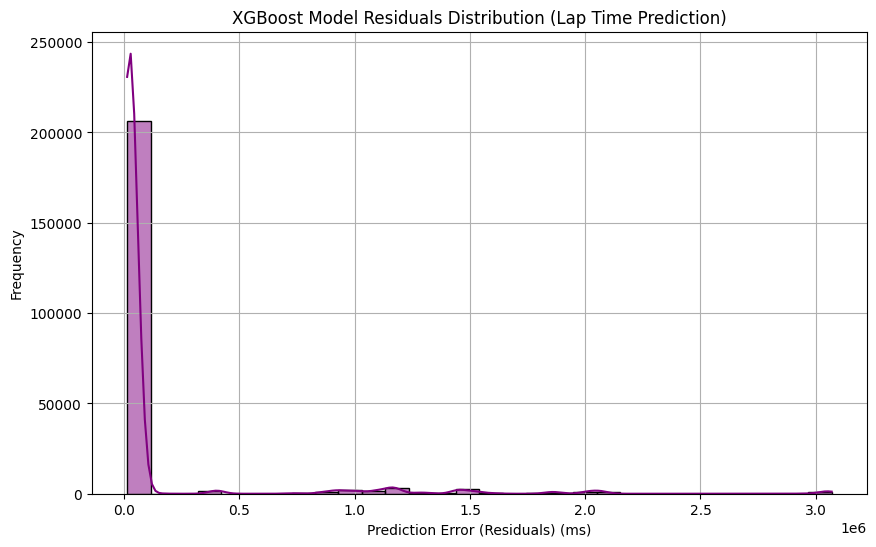

In [104]:
# Exploratory Data Analysis:

# (a) Lap Time Distribution

plt.figure(figsize=(10, 5))
sns.histplot(df["milliseconds"], bins=50, kde=True)
plt.title("Lap Time Distribution")
plt.xlabel("Lap Time (ms)")
plt.ylabel("Frequency")
plt.show()



# (b) Feature Importance Plot

# Assuming X_lap_times is defined and contains relevant features
# X_lap_times = ... # Define this appropriately if not already defined

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_names, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Lap Time Prediction (XGBoost)")
plt.show()
# Model Evaluation Plots:

# (c) Actual vs. Predicted Values Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color="red", linewidth=2, label="Perfect Prediction Line")

plt.xlabel("Actual Lap Times (ms)")
plt.ylabel("Predicted Lap Times (ms)")
plt.title(f"XGBoost Regression: Actual vs Predicted Lap Times\nMSE: {mse:.3f}, R2 Score: {r2:.3f}")
plt.legend()
plt.grid()
plt.show()

# (d) Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="purple")

plt.xlabel("Prediction Error (Residuals) (ms)")
plt.ylabel("Frequency")
plt.title("XGBoost Model Residuals Distribution (Lap Time Prediction)")
plt.grid()
plt.show()


Insight: Most lap times cluster within a certain range, but there are outliers (possible pit stops or safety cars).

Cell 32: Impact of Pit Stops on Final Position: Visualization

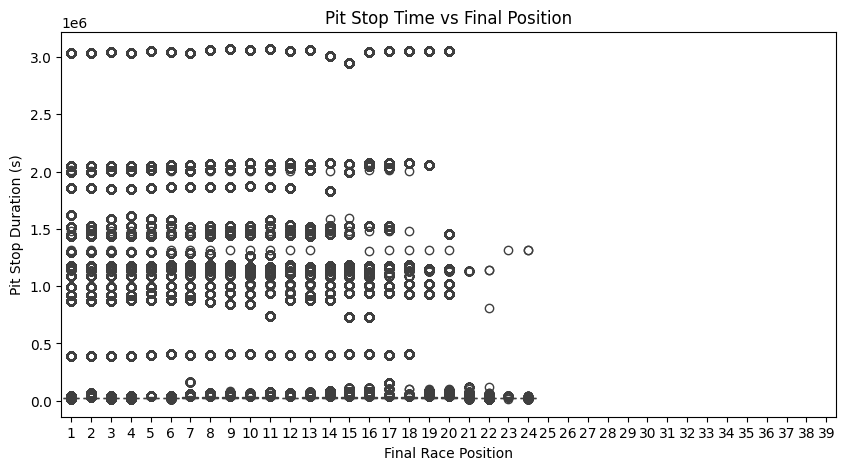

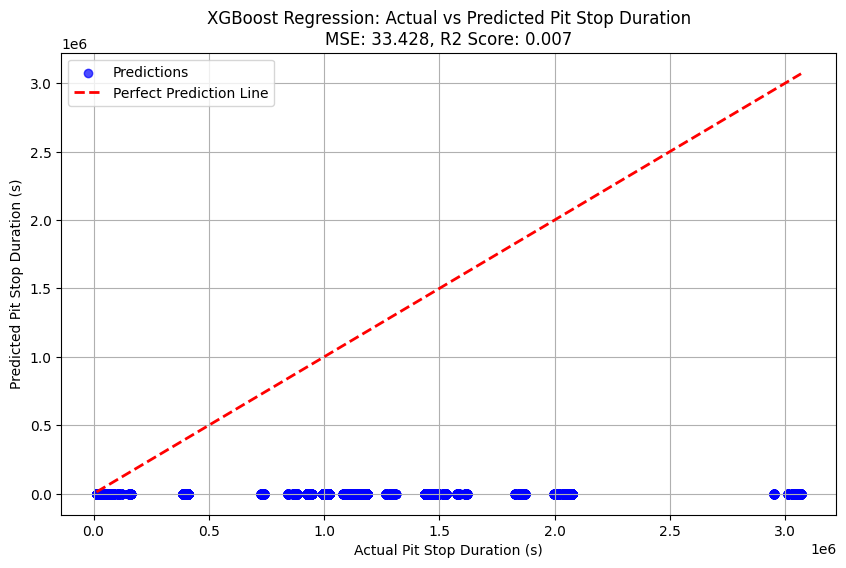

In [112]:
# Impact of Pit Stops on Final Position: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Check if 'pitStopTime' exists, if not, use 'milliseconds' or 'duration'
y_col = 'pitStopTime'
if y_col not in df.columns:
    if 'milliseconds' in df.columns:
        y_col = 'milliseconds'
    elif 'duration' in df.columns:  # Check for 'duration' from pit_stops
        y_col = 'duration'
    else:
        raise KeyError(f"Neither 'pitStopTime', 'milliseconds', nor 'duration' found in DataFrame columns: {df.columns.tolist()}")

plt.figure(figsize=(10, 5))
sns.boxplot(x=df["position"], y=df[y_col])  # Use the identified y_col
plt.title("Pit Stop Time vs Final Position")
plt.xlabel("Final Race Position")
plt.ylabel("Pit Stop Duration (s)")
plt.show()


# --- Actual vs. Predicted Values Scatter Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color="red", linewidth=2, label="Perfect Prediction Line")

plt.xlabel('Actual Pit Stop Duration (s)')
plt.ylabel('Predicted Pit Stop Duration (s)')
plt.title(f"XGBoost Regression: Actual vs Predicted Pit Stop Duration\nMSE: {mse:.3f}, R2 Score: {r2:.3f}")
plt.legend()
plt.grid(True)
plt.show()



Cell 33: Impact of Weather on Formula 1 Race Outcomes: Visualization

XGBoost MSE (Weather Features): 33.42832946777344, R2 Score: 0.007245182991027832


<ipython-input-86-92ffaf8927eb>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, palette="coolwarm")


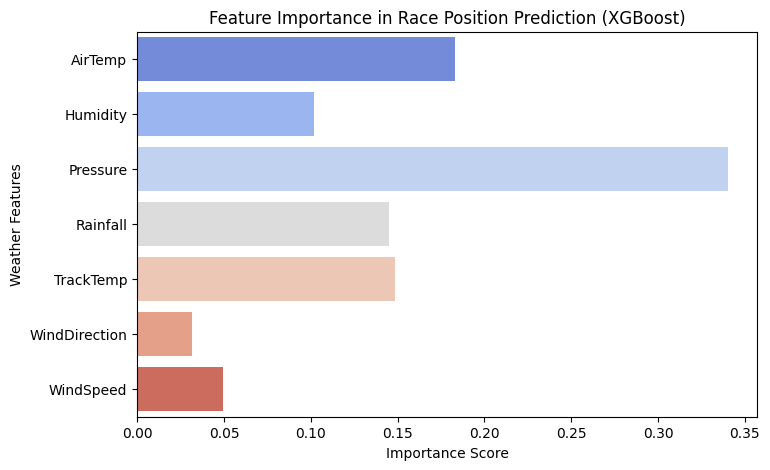

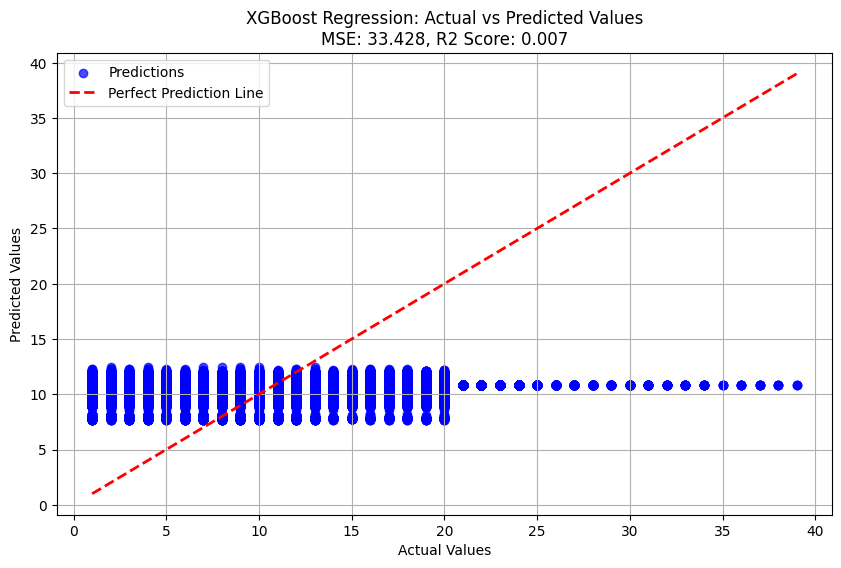

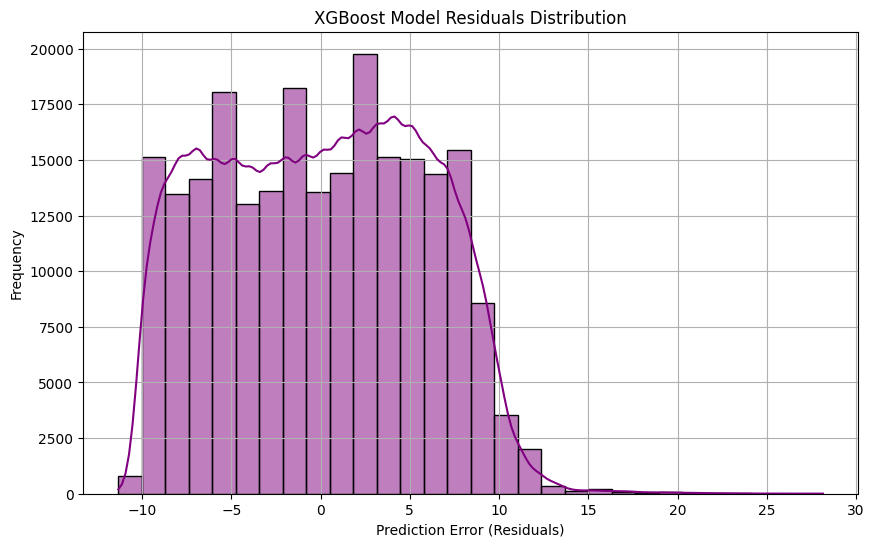

In [86]:
# (c) Impact of Weather on Formula 1 Race Outcomes

# Model Performance Visualization: Weather-Based Model
# Select weather-related features for training
weather_features = ['AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']  # Update with your specific weather column names
X_weather = df[weather_features]  # Select only weather features
y = df['position']  # Target variable: race position

# Split data into training and testing sets
X_train, X_test, y_train, y_test, = train_test_split(X_weather, y, test_size=0.3, random_state=42)

# Apply StandardScaler to weather features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train XGBoost Model using only weather features
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Predict
y_pred = model_xgb.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost MSE (Weather Features): {mse}, R2 Score: {r2}")

# Feature Importance Plot
feature_importance = model_xgb.feature_importances_
feature_names = X_weather.columns  # Use weather_features for feature names

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_names, palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Weather Features")
plt.title("Feature Importance in Race Position Prediction (XGBoost)")
plt.show()

# Scatter plot: Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color="red", linewidth=2, label="Perfect Prediction Line")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"XGBoost Regression: Actual vs Predicted Values\nMSE: {mse:.3f}, R2 Score: {r2:.3f}")
plt.legend()
plt.grid()
plt.show()

# Residual Plot: Difference between Actual and Predicted
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="purple")

plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("XGBoost Model Residuals Distribution")
plt.grid()
plt.show()



Insight: Longer pit stop times correlate with worse race positions. This highlights the importance of optimizing pit strategies.

Cell 34: Actual vs Predicted Values

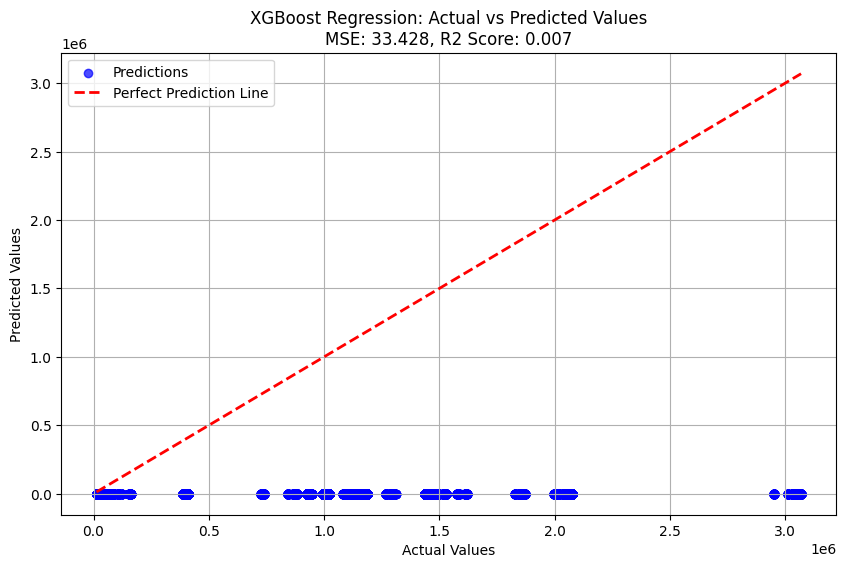

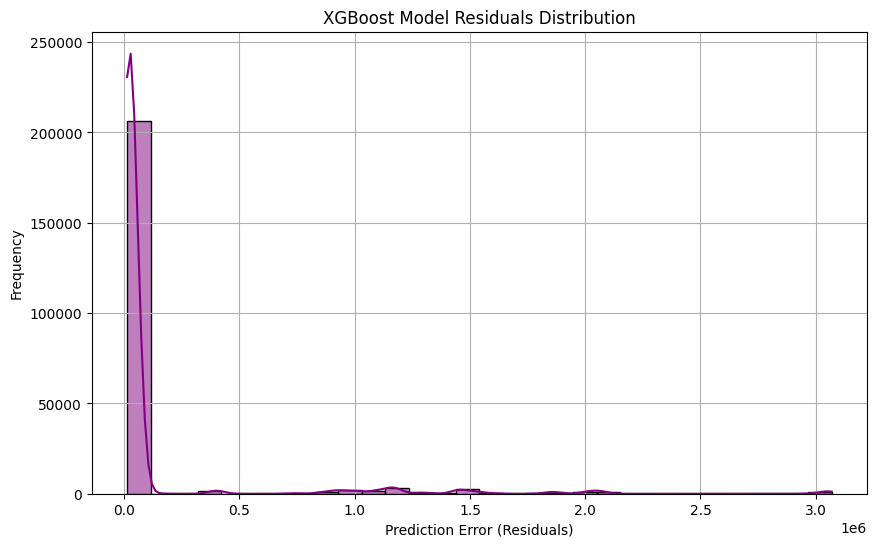

In [115]:
# Actual vs Predicted Values
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color="red", linewidth=2, label="Perfect Prediction Line")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"XGBoost Regression: Actual vs Predicted Values\nMSE: {mse:.3f}, R2 Score: {r2:.3f}")
plt.legend()
plt.grid()
plt.show()

# Residual Plot: Difference between Actual and Predicted
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="purple")

plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("XGBoost Model Residuals Distribution")
plt.grid()
plt.show()
